In [25]:
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import pandas_ta as pta
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
import ta
import pandas as pd

In [26]:
class RsiStAggressiveStrategy(Strategy):
    def __init__(self, params: dict):
        super().__init__()
        self.rsi_length = params.get('rsi_length', 14)
        self.rsi_oversold = params.get('rsi_oversold', 30)
        self.supertrend_length = params.get('supertrend_length', 10)
        self.supertrend_multiplier = params.get('supertrend_multiplier', 3)
        self.trail_percentage = params.get('trail_percentage', 0.02)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.05)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        supertrend_data = pta.supertrend(data['high'], data['low'], data['close'], length=self.supertrend_length, multiplier=self.supertrend_multiplier)
        data['supertrend'] = supertrend_data[f'SUPERT_{self.supertrend_length}_{self.supertrend_multiplier}.0']

        # Calculate RSI
        data['rsi'] = pta.rsi(data['close'], length=self.rsi_length)

        # Define Supertrend trend direction for entry and exit
        data['supertrend_signal'] = (data['supertrend'] < data['close'])

        # Define RSI signal (oversold condition)
        data['rsi_signal'] = data['rsi'] < self.rsi_oversold

        # Combine signals
        data['long_entry'] = data['supertrend_signal'] & data['rsi_signal']
        
        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)
        # No need to implement exit logic as we're using trailing stop loss


In [27]:
class RsiStDefensiveStrategy(Strategy):
    def __init__(self, params: dict):
        super().__init__()
        self.rsi_length = params.get('rsi_length', 7)
        self.rsi_oversold = params.get('rsi_oversold', 35)
        self.supertrend_length = params.get('supertrend_length', 10)
        self.supertrend_multiplier = params.get('supertrend_multiplier', 3)
        self.trail_percentage = params.get('trail_percentage', 0.02)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.05)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate RSI
        data['rsi'] = pta.rsi(data['close'], length=self.rsi_length)
        data['rsi_minus_two'] = data['rsi'].shift(2)

        # Calculate SuperTrend
        supertrend = pta.supertrend(data['high'], data['low'], data['close'], length=self.supertrend_length, multiplier=self.supertrend_multiplier)
        data['supertrend'] = supertrend[f'SUPERT_{self.supertrend_length}_{self.supertrend_multiplier}.0']
        data['supertrend_direction'] = supertrend[f'SUPERTd_{self.supertrend_length}_{self.supertrend_multiplier}.0']
        data['supertrend_direction_minus_one'] = data['supertrend_direction'].shift(1)

        # Define RSI signal (oversold condition)
        data['rsi_signal'] = data['rsi_minus_two'] < self.rsi_oversold

        # Define SuperTrend signal (bullish condition)
        data['supertrend_signal'] = (data['supertrend_direction'] == 1) & (data['supertrend_direction_minus_one'] == 1)

        # Update combined signals
        data['long_entry'] = data['rsi_signal'] & data['supertrend_signal']

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


In [28]:
class CciStAdxStrategy(Strategy):
    def __init__(self, params: dict):
        super().__init__()
        self.supertrend_length = params.get('supertrend_length', 10)
        self.supertrend_multiplier = params.get('supertrend_multiplier', 3)
        self.cci_length = params.get('cci_length', 24)
        self.cci_threshold = params.get('cci_threshold', -50)
        self.adx_length = params.get('adx_length', 12)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.trail_percentage = params.get('trail_percentage', 0.02)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.05)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate SuperTrend
        supertrend = pta.supertrend(data['high'], data['low'], data['close'], length=self.supertrend_length, multiplier=self.supertrend_multiplier)
        data['supertrend'] = supertrend[f'SUPERT_{self.supertrend_length}_{self.supertrend_multiplier}.0']
        data['supertrend_direction'] = supertrend[f'SUPERTd_{self.supertrend_length}_{self.supertrend_multiplier}.0']
        data['supertrend_direction_minus_one'] = data['supertrend_direction'].shift(1)

        # Calculate CCI
        data['cci'] = pta.cci(data['high'], data['low'], data['close'], length=self.cci_length)
        data['cci_minus_two'] = data['cci'].shift(2)

        # Calculate ADX
        data['adx'] = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)['ADX_' + str(self.adx_length)]
        data['adx_minus_two'] = data['adx'].shift(2)

        # Define SuperTrend signal for entry
        data['supertrend_signal'] = (data['supertrend_direction'] == 1) & (data['supertrend_direction_minus_one'] == 1)

        # Define CCI signal (oversold condition)
        data['cci_signal'] = data['cci_minus_two'] < self.cci_threshold

        # Define ADX signal (strong trend)
        data['adx_signal'] = data['adx_minus_two'] > self.adx_threshold

        # Combine signals
        data['long_entry'] = data['cci_signal'] & data['adx_signal'] & data['supertrend_signal']

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


In [29]:
class AdxEmaRsiStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.ema_length = params.get('ema_length', 72)
        self.rsi_length = params.get('rsi_length', 48)
        self.rsi_overbought = params.get('rsi_overbought', 70)
        self.trail_percentage = params.get('trail_percentage', 0.02)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.05)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Calculate RSI
        data['rsi'] = pta.rsi(data['close'], length=self.rsi_length)

        # Calculate EMA
        data['ema'] = pta.ema(data['close'], length=self.ema_length)

        # Define signals
        data['strong_trend'] = data['adx'] > self.adx_threshold
        data['not_overbought'] = data['rsi'] < self.rsi_overbought
        data['ema_buy'] = data['close'] > data['ema']

        # Combine all conditions for long entry
        data['long_entry'] = (
            data['strong_trend'] &
            data['not_overbought'] &
            data['ema_buy']
        )

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


In [32]:
class AdxEmaStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.ema_length_short = params.get('ema_length_short', 24)
        self.ema_length_long = params.get('ema_length_long', 168)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Calculate EMA
        data['ema_short'] = pta.ema(data['close'], length=self.ema_length_short)
        data['ema_long'] = pta.ema(data['close'], length=self.ema_length_long)

        # Define signals
        data['strong_trend'] = data['adx'] > self.adx_threshold
        data['ema_buy'] = (data['close'] > data['ema_long']) & (data['close'] < data['ema_short'])

        # Combine all conditions for long entry
        data['long_entry'] = (data['strong_trend'] & data['ema_buy'])

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for BTC-GBP at 14855.134765625 with quantity 0.06704752368216535, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 14855.134765625 with quantity 0.06704752368216535, total cost £999.984 and transaction cost £3.984
        Bought 0.06704752368216535 BTC-GBP at 14855.134765625 on 12/01/2023 14:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 14855.134765625 with quantity 0.06704752368216535, trail 0.1, limit None, stop None, take_profit None
    Updated trailing stop to 13411.3556640625
Request to open long position on BTC-GBP
    Already long on BTC-GBP
Request to open long position on BTC-GBP
    Already long on BTC-GBP
    Updated trailing stop to 13855.5109375
    Creating TRAILING_STOP SELL order for BTC-GBP at 15341.0244140625 with quantity 0.06704752368216535, trail 0.07142230228946773

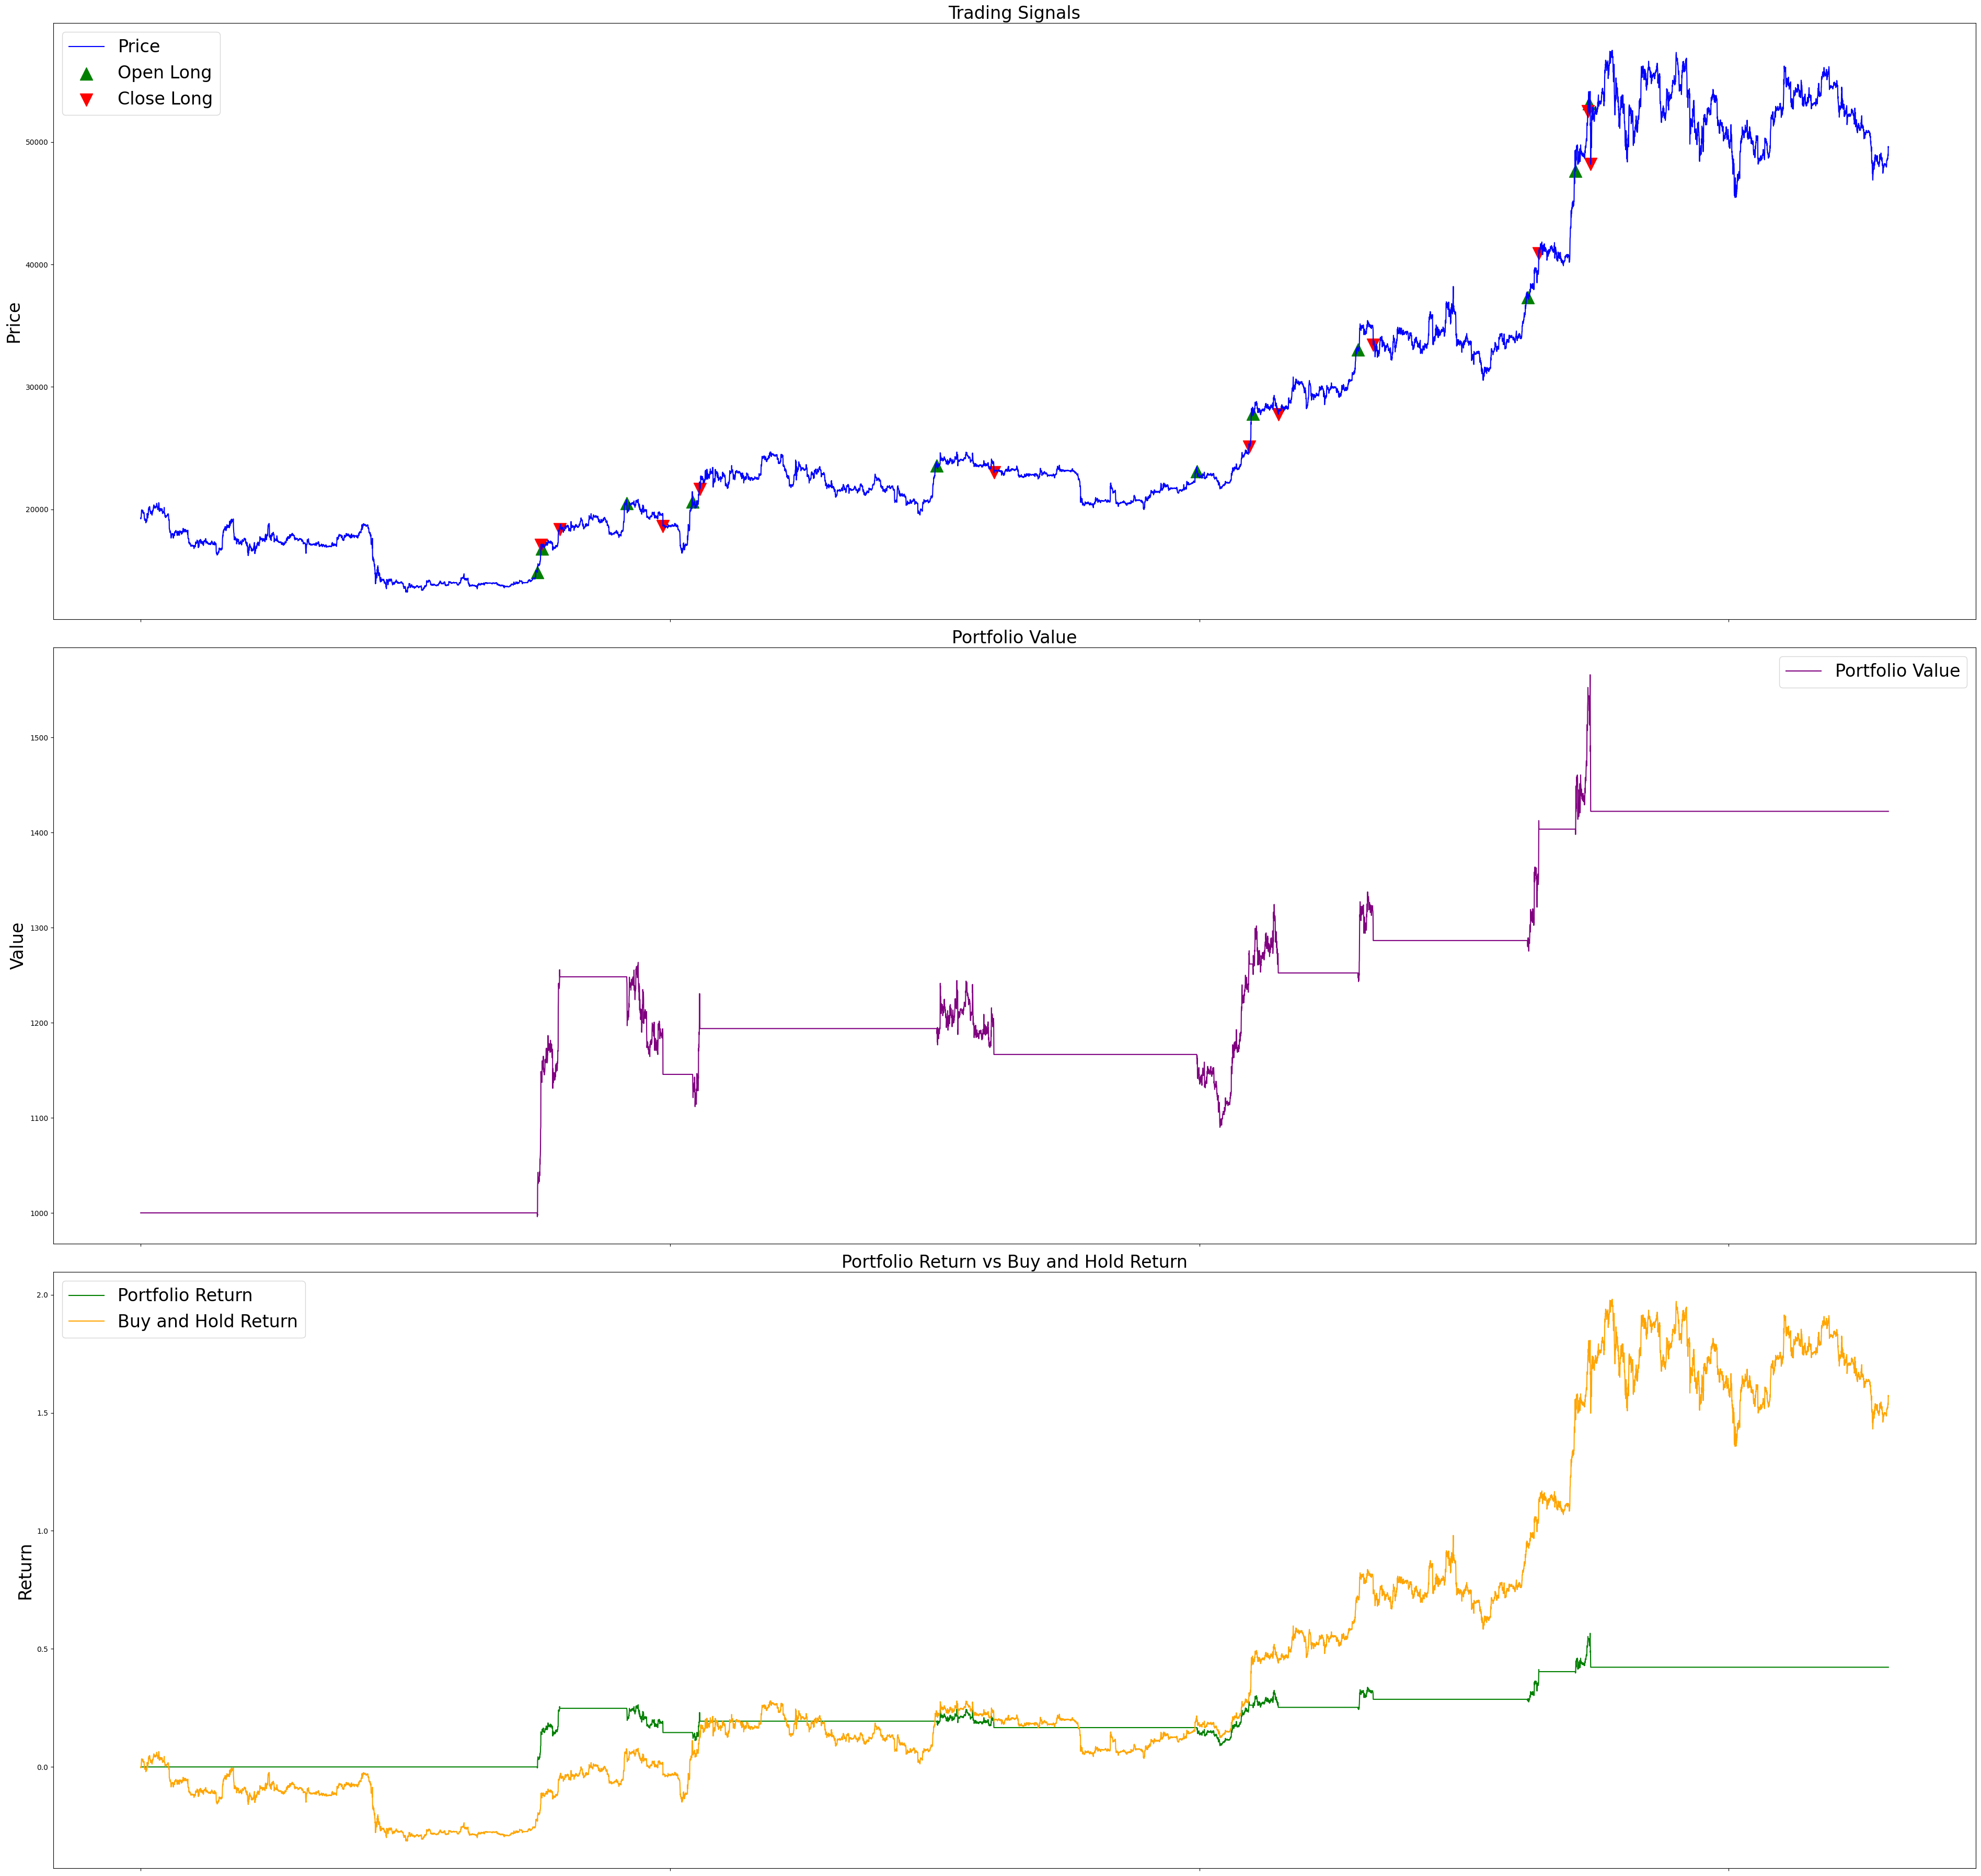

In [44]:
import csv
from datetime import datetime

# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
#SYMBOL = "AAPL"
train_since = pd.to_datetime('2022-08-01').tz_localize('UTC')
start_date = pd.to_datetime('2022-08-08').tz_localize('UTC')
end_date = pd.to_datetime('2024-07-01').tz_localize('UTC')
period = 168
frequency = '1h'

feed = YFinanceFeed(interval = frequency)

strategy_params = {
    'trail_percentage': 0.1,
    'take_profit_percentage': 0.1,
    
    #'cci_length': 24,
    #'cci_threshold': -50,
    #'adx_length': 12,
    #'adx_threshold': 30,
    
    #'rsi_length': 7,
    #'rsi_oversold': 35,
    #'supertrend_length': 10,
    #'supertrend_multiplier': 3,
    # AdxEmaRsiStrategy parameters
    
    #'rsi_length': 48,
    #'rsi_overbought': 70,
    #'ema_length': 72,
    #'adx_length': 24,
    #'adx_threshold': 30,

    'adx_length': 48,
    'adx_threshold': 30,
    'ema_length_short': 12,
    'ema_length_long': 72,
}

strategy = AdxEmaStrategy(strategy_params)

trader = Trader(SYMBOL, 1000, feed, strategy)

# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

perf = portfolio.plot_performance()


In [45]:
import os

# CSV file path
csv_file = f'performance_tests.csv'

# Define the header
header = [
    'strategy', 'symbol', 'start_date', 'end_date', 'frequency', 'cci_length', 'cci_threshold',
    'adx_length', 'adx_threshold', 'rsi_length', 'rsi_oversold', 'supertrend_length',
    'supertrend_multiplier', 'trail_percentage', 'take_profit_percentage',
    'win_rate', 'portfolio_return', 'asset_return', 'portfolio_max_drawdown', 'asset_max_drawdown'
]

# Check if the file exists and is empty
file_exists = os.path.isfile(csv_file)
file_empty = file_exists and os.path.getsize(csv_file) == 0

# Open the file in append mode
with open(csv_file, 'a', newline='') as f:
    writer = csv.writer(f)
    
    # Write header if file is empty or doesn't exist
    if not file_exists or file_empty:
        writer.writerow(header)
    
    # Write the data
    writer.writerow([
        strategy.__class__.__name__,
        SYMBOL,
        start_date.strftime('%Y-%m-%d'),
        end_date.strftime('%Y-%m-%d'),
        frequency,
        strategy_params.get('cci_length', ''),
        strategy_params.get('cci_threshold', ''),
        strategy_params.get('adx_length', ''),
        strategy_params.get('adx_threshold', ''),
        strategy_params.get('rsi_length', ''),
        strategy_params.get('rsi_oversold', ''),
        strategy_params.get('supertrend_length', ''),
        strategy_params.get('supertrend_multiplier', ''),
        strategy_params['trail_percentage'],
        strategy_params['take_profit_percentage'],
        perf['win_rate'],
        perf['portfolio_return'],
        perf['asset_return'],
        perf['portfolio_max_drawdown'],
        perf['asset_max_drawdown'],
    ])